# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from missingno import matrix
from fastai.tabular.core import add_datepart
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, AffinityPropagation, SpectralClustering
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
import gower
import warnings
import h2o
import xgboost as xgb
from xgboost import XGBClassifier
from h2o.automl import H2OAutoML
warnings.filterwarnings('ignore')

## Removing column display limit

In [2]:
pd.set_option('display.max_columns', None)

# Data pull

In [3]:
df = pd.read_csv("/teamspace/studios/this_studio/longbeach_animal_shelter_complete.csv", sep=None, engine='python')

# Data transformation

## Removing whitespaces

In [4]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '') # Removing whitespaces in column names

## Date time conversion

In [5]:
# Convert *dob*, *intake_date*, *outcome_date* to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['intake_date'] = pd.to_datetime(df['intake_date'], errors='coerce')
df['outcome_date'] = pd.to_datetime(df['outcome_date'], errors='coerce')

## Adding time to outcome variable

In [6]:
df['time_to_outcome'] = df['outcome_date'] - df['intake_date'] # Calculate time to outcome in days

## Dealing with duplicates

In this context, duplicate animal IDs reflect returning animals. This analysis will keep counts for returning cases, note time time between visits, and identify animals that return more than twice.

In [7]:
df = df.sort_values(['animal_id', 'intake_date'])

In [8]:
# Create visit_count using groupby and cumcount
df['visit_count'] = df.groupby('animal_id').cumcount() + 1

In [9]:
# Additional useful features
df['is_return_visit'] = (df['visit_count'] > 1).astype(int)
df['is_frequent_returner'] = (df['visit_count'] > 2).astype(int)

In [10]:
# Advanced features for return animals
df['days_since_last_visit'] = df.groupby('animal_id')['intake_date'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(-1)
df['previous_outcome_type'] = df.groupby('animal_id')['outcome_type'].shift(1)
df['previous_outcome_type'] = df['previous_outcome_type'].fillna('First Visit')

## Date of birth imputation

In [11]:
def impute_dob_statistical(df):
    """Impute DOB using statistical measures from similar animals"""
    df_imputed = df.copy()
    
    # Calculate age for animals with known DOB
    known_mask = df_imputed['dob'].notna()
    df_imputed.loc[known_mask, 'age_at_intake_days'] = (
        df_imputed.loc[known_mask, 'intake_date'] - df_imputed.loc[known_mask, 'dob']
    ).dt.days
    
    # Group by animal_type and intake_type for imputation
    imputation_groups = ['animal_type', 'intake_type', 'sex']
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        # Get characteristics of current animal
        animal_info = df_imputed.loc[idx]
        
        # Find similar animals with known DOB
        similar_animals = df_imputed[
            (df_imputed['animal_type'] == animal_info['animal_type']) &
            (df_imputed['intake_type'] == animal_info['intake_type']) &
            (df_imputed['sex'] == animal_info['sex']) &
            (df_imputed['dob'].notna())
        ]
        
        # If no exact match, broaden the criteria
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['intake_type'] == animal_info['intake_type']) &
                (df_imputed['dob'].notna())
            ]
        
        # If still no match, use animal_type only
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['dob'].notna())
            ]
        
        if len(similar_animals) > 0:
            # Use median age of similar animals
            median_age_days = similar_animals['age_at_intake_days'].median()
            
            # FIX: Check if median is valid and convert to int
            if pd.notna(median_age_days):
                # Calculate imputed DOB
                imputed_dob = animal_info['intake_date'] - timedelta(days=int(median_age_days))
                df_imputed.loc[idx, 'dob'] = imputed_dob
                imputed_count += 1
    
    print(f"Strategy 1: Imputed DOB for {imputed_count} animals using statistical method")
    return df_imputed

def impute_dob_domain_knowledge(df):
    """Impute DOB using domain knowledge about animal shelters"""
    df_imputed = df.copy()
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        animal_info = df_imputed.loc[idx]
        intake_date = animal_info['intake_date']
        
        # Define typical ages based on intake type and condition
        if animal_info['intake_type'] == 'WILDLIFE':
            # Wildlife often comes in as injured adults or orphaned babies
            if 'WEIGHT' in str(animal_info['intake_cond']).upper():
                # Likely a baby if underweight
                estimated_age_days = np.random.normal(30, 15)  # 1 month ± 2 weeks
            else:
                # Likely adult wildlife
                estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
                
        elif animal_info['intake_type'] == 'STRAY':
            # Strays are often young adults who got lost
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(548, 365)  # 1.5 years ± 1 year
            else:  # DOG
                estimated_age_days = np.random.normal(730, 365)  # 2 years ± 1 year
                
        elif animal_info['intake_type'] == 'OWNER SURRENDER':
            # Owner surrenders often older animals due to life changes
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(1095, 730)  # 3 years ± 2 years
            else:  # DOG
                estimated_age_days = np.random.normal(1460, 1095)  # 4 years ± 3 years
                
        else:
            # Default for other types
            estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
        
        # Ensure positive age and not born in the future
        estimated_age_days = max(1, estimated_age_days)
        estimated_age_days = min(estimated_age_days, 5475)  # Max 15 years
        
        # FIX: Convert to int for timedelta
        # Calculate DOB
        imputed_dob = intake_date - timedelta(days=int(estimated_age_days))
        df_imputed.loc[idx, 'dob'] = imputed_dob
        imputed_count += 1
    
    print(f"Strategy 2: Imputed DOB for {imputed_count} animals using domain knowledge")
    return df_imputed

def impute_dob_hybrid(df):
    """Combine multiple strategies for best results"""
    df_imputed = df.copy()
    
    print("Hybrid DOB Imputation Strategy:")
    print("=" * 40)
    
    # First, try statistical imputation for animals with many similar examples
    df_imputed = impute_dob_statistical(df_imputed)
    
    # Then, use domain knowledge for remaining missing values
    remaining_missing = df_imputed['dob'].isna().sum()
    if remaining_missing > 0:
        print(f"Applying domain knowledge to {remaining_missing} remaining missing DOBs")
        df_imputed = impute_dob_domain_knowledge(df_imputed)
    # Calculate age for ALL animals after imputation
    df_imputed['age_at_intake_days'] = (df_imputed['intake_date'] - df_imputed['dob']).dt.days
    
    return df_imputed

In [12]:
df = impute_dob_hybrid(df)

Hybrid DOB Imputation Strategy:


Strategy 1: Imputed DOB for 4121 animals using statistical method
Applying domain knowledge to 21 remaining missing DOBs
Strategy 2: Imputed DOB for 21 animals using domain knowledge


## Deleting values where DOB is after intake date
This measure is undertaken to ensure logical consistency.

In [13]:
df = df[(df['dob'] <= df['intake_date']) | df['dob'].isnull() | df['intake_date'].isnull()]

## Replace null values of secondary color to 'None'

This step can help classify animals with more colours/patterns.

In [14]:
df['secondary_color'] = df['secondary_color'].fillna('None')

## Dropping columns *reason*, *geopoint*, *was_outcome_alive*, *animal_id*

These features either don't convey any information, or, contain too many null values to impute.

In [15]:
df = df.drop(columns=['reason', 'geopoint', 'was_outcome_alive', 'animal_id'], axis=1)

## Making a binary column for name of animal

A binary variable with a name indicator is better for classification ML models instead of the name.

In [16]:
# New column called has_name where if animal_name is not null, then 1, else 0
df['has_name'] = df['animal_name'].notnull().astype(int)

## Dropping animal_name column

In [17]:
df = df.drop(columns=['animal_name'])

## Dropping null values for outocme_type & intake_subtype

The target variable nulls are small in number and would be better off excluded from the analysis. 

Knowing more about the intake reason will help the analysis become robust.

In [18]:
df = df.dropna(subset=['intake_subtype', 'outcome_type'])

## Dropping the *crossing* feature

In [19]:
df = df.drop(columns=['crossing'])

## Dropping *intake_is_dead* column

Can drop this column since no information is being conveyed through only 1 possible outcome here.

In [20]:
df = df.drop(columns=['intake_is_dead'], axis=1)

## Intake month feature creation

In [21]:
df['intake_month'] = df['intake_date'].dt.month

## Adding *is_fixed* column

In [22]:
df['is_fixed'] = df['sex'].str.contains('Spayed|Neutered', case=False, na=False).astype(int)

## Making changes to the *sex* column

Since the sex column contains the fix status, we want to change that to just male, female, and unknown options. The way we can do that is by changing "neutered" to male and "spayed" to female

In [23]:
df['sex'] = df['sex'].replace({'Neutered': 'Male', 'Spayed': 'Female'})

## Datetime feature engineering using fastai

In [24]:

for col in ['dob','intake_date','outcome_date']:
    df[col] = pd.to_datetime(df[col], utc=True)

# Explode each date column into date‐parts + an “Elapsed” (epoch seconds)
for col in ['dob','intake_date','outcome_date']:
    add_datepart(df, col, drop=True)  # drop=True removes the original datetime

## Dropping redundant date columns

Some date columns created above don't add meaningful information to the analysis and are thus, dropped. 

In [25]:
df = df.drop(columns=['intake_month', 'intake_Year', 'intake_Week', 'intake_Day', 'intake_Dayofyear', 'intake_Is_month_end', 'intake_Is_month_start', 'intake_Is_quarter_end', 'intake_Is_quarter_start', 'intake_Is_year_end', 'intake_Is_year_start', 'outcome_Year','outcome_Week', 'outcome_Day', 'outcome_Dayofyear', 'outcome_Is_month_end', 'outcome_Is_month_start', 'outcome_Is_quarter_end', 'outcome_Is_quarter_start', 'outcome_Is_year_end', 'outcome_Is_year_start', 'dobYear', 'dobWeek', 'dobDay', 'dobIs_month_end', 'dobIs_month_start', 'dobIs_quarter_end', 'dobIs_quarter_start', 'dobIs_year_end', 'dobIs_year_start', 'dobDayofyear'])

## Dealing with features that have high cardinality

### *primary_color*

In [26]:
def extract_base_color_and_pattern(color):
    """Extract base color and pattern information from primary color"""
    color = str(color).upper().strip()
    
    # Define pattern keywords
    pattern_keywords = ['TABBY', 'BRINDLE', 'MERLE', 'PT', 'POINT', 'SMOKE', 'TIGER', 'LYNX']
    
    # Check if it has a pattern
    has_pattern = any(keyword in color for keyword in pattern_keywords)
    
    # Extract base color
    if color in ['TRICOLOR', 'CALICO', 'CALICO DIL', 'CALICO PT', 'CALICO TAB']:
        base_color = 'Multicolor'
    elif 'BLACK' in color or 'BLK' in color:
        base_color = 'Black'
    elif 'WHITE' in color:
        base_color = 'White'
    elif 'BROWN' in color or 'BRN' in color or 'BR ' in color:
        base_color = 'Brown'
    elif 'GRAY' in color or 'GREY' in color:
        base_color = 'Gray'
    elif 'RED' in color or 'RD ' in color:
        base_color = 'Red'
    elif 'BLUE' in color or 'BL ' in color or 'BC ' in color:
        base_color = 'Blue'
    elif 'CREAM' in color or 'CRM' in color or 'CR ' in color:
        base_color = 'Cream'
    elif 'TAN' in color:
        base_color = 'Tan'
    elif 'YELLOW' in color:
        base_color = 'Yellow'
    elif 'ORANGE' in color or 'ORG' in color:
        base_color = 'Orange'
    elif 'GOLD' in color:
        base_color = 'Gold'
    elif 'SILVER' in color or 'SLVR' in color or 'SL ' in color:
        base_color = 'Silver'
    elif 'CHOCOLATE' in color or 'CHOC' in color or 'CH ' in color:
        base_color = 'Chocolate'
    elif 'BUFF' in color:
        base_color = 'Buff'
    elif 'BLONDE' in color:
        base_color = 'Blonde'
    elif 'APRICOT' in color:
        base_color = 'Apricot'
    elif 'TORTIE' in color or 'TORBI' in color:
        base_color = 'Tortoiseshell'
    elif 'SABLE' in color:
        base_color = 'Sable'
    elif 'WHEAT' in color:
        base_color = 'Wheat'
    elif 'FAWN' in color:
        base_color = 'Fawn'
    elif 'SEAL' in color:
        base_color = 'Seal'
    elif 'LILAC' in color:
        base_color = 'Lilac'
    elif 'LIVER' in color:
        base_color = 'Liver'
    elif 'PINK' in color:
        base_color = 'Pink'
    elif 'GREEN' in color:
        base_color = 'Green'
    elif 'FLAME' in color:
        base_color = 'Flame'
    elif 'PEACH' in color:
        base_color = 'Peach'
    elif 'RUDDY' in color:
        base_color = 'Ruddy'
    elif 'DAPPLE' in color:
        base_color = 'Dapple'
    elif 'SNOWSHOE' in color:
        base_color = 'Snowshoe'
    elif 'TICK' in color:
        base_color = 'Tick'
    elif 'UNKNOWN' in color:
        base_color = 'Unknown'
    else:
        base_color = 'Other'
    
    return base_color, int(has_pattern)

# Apply transformation
print("Extracting base colors and patterns...")
primary_color_info = df['primary_color'].apply(extract_base_color_and_pattern)
df['primary_base_color'] = [info[0] for info in primary_color_info]
df['has_pattern'] = [info[1] for info in primary_color_info]

# Display results
print("Primary color transformation results:")
print(f"primary_base_color unique values: {df['primary_base_color'].nunique()}")
print("Base color distribution:")
print(df['primary_base_color'].value_counts().head(10))
print(f"\nPattern distribution:")
print(df['has_pattern'].value_counts())

Extracting base colors and patterns...
Primary color transformation results:
primary_base_color unique values: 33
Base color distribution:
primary_base_color
Black            7929
Brown            6499
Gray             5507
White            3850
Orange           1488
Tan              1476
Multicolor       1076
Tortoiseshell     664
Blue              400
Cream             332
Name: count, dtype: int64

Pattern distribution:
has_pattern
0    25710
1     5731
Name: count, dtype: int64


### *secondary_color*

In [27]:
# Create binary secondary color feature
df['has_secondary_color'] = (df['secondary_color'] != 'None').astype(int)

print("Secondary color transformation results:")
print("has_secondary_color distribution:")
print(df['has_secondary_color'].value_counts())
print(f"Percentage with secondary color: {df['has_secondary_color'].mean()*100:.1f}%")

print("\n" + "="*60)
print("TRANSFORMING ANIMAL TYPE")
print("="*60)

Secondary color transformation results:
has_secondary_color distribution:
has_secondary_color
0    16526
1    14915
Name: count, dtype: int64
Percentage with secondary color: 47.4%

TRANSFORMING ANIMAL TYPE


### *animal_type*

In [28]:
def categorize_animal_type(animal_type):
    """Categorize animal type into Cat, Dog, Other"""
    animal_type = str(animal_type).upper().strip()
    
    if animal_type == 'CAT':
        return 'Cat'
    elif animal_type == 'DOG':
        return 'Dog'
    else:  # OTHER, RABBIT, REPTILE, BIRD, LIVESTOCK, WILD, GUINEA PIG
        return 'Other'

# Apply transformation
df['animal_type_grouped'] = df['animal_type'].apply(categorize_animal_type)

print("Animal type transformation results:")
print("Original vs. Grouped:")
print(pd.crosstab(df['animal_type'], df['animal_type_grouped'], margins=True))

print("\nGrouped animal type distribution:")
print(df['animal_type_grouped'].value_counts())

Animal type transformation results:
Original vs. Grouped:
animal_type_grouped    Cat    Dog  Other    All
animal_type                                    
AMPHIBIAN                0      0      2      2
BIRD                     0      0   2339   2339
CAT                  14766      0      0  14766
DOG                      0  10061      0  10061
GUINEA PIG               0      0    199    199
LIVESTOCK                0      0     11     11
OTHER                    0      0   1561   1561
RABBIT                   0      0    612    612
REPTILE                  0      0    344    344
WILD                     0      0   1546   1546
All                  14766  10061   6614  31441

Grouped animal type distribution:
animal_type_grouped
Cat      14766
Dog      10061
Other     6614
Name: count, dtype: int64


### *outcome_type*

In [29]:
def categorize_outcome_type(outcome_type):
    """Categorize outcome type into 6 main categories"""
    outcome_type = str(outcome_type).upper().strip()
    
    if outcome_type == 'RESCUE':
        return 'Rescue'
    elif outcome_type == 'ADOPTION':
        return 'Adoption'
    elif outcome_type == 'EUTHANASIA':
        return 'Euthanasia'
    elif outcome_type == 'TRANSFER':
        return 'Transfer'
    elif outcome_type == 'RETURN TO OWNER':
        return 'Return to Owner'
    else:  # All other outcomes go to 'Other'
        return 'Other'

# Apply transformation
df['outcome_type_grouped'] = df['outcome_type'].apply(categorize_outcome_type)

print("Outcome type transformation results:")
print("Original vs. Grouped mapping:")
outcome_mapping = df.groupby('outcome_type')['outcome_type_grouped'].first().sort_values()
for original, grouped in outcome_mapping.items():
    count = (df['outcome_type'] == original).sum()
    print(f"  {original} → {grouped} ({count:,} records)")

print("\nGrouped outcome type distribution:")
grouped_counts = df['outcome_type_grouped'].value_counts()
for outcome, count in grouped_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {outcome}: {count:,} ({percentage:.1f}%)")

Outcome type transformation results:
Original vs. Grouped mapping:
  ADOPTION → Adoption (6,676 records)
  EUTHANASIA → Euthanasia (5,713 records)
  SHELTER, NEUTER, RETURN → Other (871 records)
  RETURN TO WILD HABITAT → Other (321 records)
  RETURN TO RESCUE → Other (43 records)
  MISSING → Other (69 records)
  TRANSPORT → Other (334 records)
  HOMEFIRST → Other (88 records)
  FOSTER → Other (12 records)
  DUPLICATE → Other (31 records)
  DISPOSAL → Other (80 records)
  DIED → Other (744 records)
  COMMUNITY CAT → Other (489 records)
  FOSTER TO ADOPT → Other (222 records)
  TRAP, NEUTER, RELEASE → Other (6 records)
  RESCUE → Rescue (7,417 records)
  RETURN TO OWNER → Return to Owner (3,265 records)
  TRANSFER → Transfer (5,060 records)

Grouped outcome type distribution:
  Rescue: 7,417 (23.6%)
  Adoption: 6,676 (21.2%)
  Euthanasia: 5,713 (18.2%)
  Transfer: 5,060 (16.1%)
  Other: 3,310 (10.5%)
  Return to Owner: 3,265 (10.4%)


## Preprocessing

### Dropping all outcome related columns

Since outcome is the target variable, any information related to outcome will be dropped from the dataset

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31441 entries, 3190 to 30595
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31441 non-null  object         
 1   primary_color          31441 non-null  object         
 2   secondary_color        31441 non-null  object         
 3   sex                    31441 non-null  object         
 4   intake_cond            31441 non-null  object         
 5   intake_type            31441 non-null  object         
 6   intake_subtype         31441 non-null  object         
 7   jurisdiction           31441 non-null  object         
 8   outcome_type           31441 non-null  object         
 9   outcome_subtype        28114 non-null  object         
 10  latitude               31441 non-null  float64        
 11  longitude              31441 non-null  float64        
 12  outcome_is_dead        31441 non-null  bool     

outcome_type, outcome_subtype, outcome_is_dead, time_to_outcome, outcome_Month, outcome_Dayofweek, outcome_Elapsed, intake_duration, is_current_month, latitude, longitude

In [31]:
df.head()

,animal_type,primary_color,secondary_color,sex,intake_cond,intake_type,intake_subtype,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,intake_duration,is_current_month,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,is_fixed,dobMonth,dobDayofweek,dobElapsed,intake_Month,intake_Dayofweek,intake_Elapsed,outcome_Month,outcome_Dayofweek,outcome_Elapsed,primary_base_color,has_pattern,has_secondary_color,animal_type_grouped,outcome_type_grouped
3190,DOG,TRICOLOR,None,Female,AGED,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1.0,0,1 days,1,0,0,-1.0,First Visit,5408,1,1,8,0,1.156118e+09,6,4,1.623370e+09,6,5,1.623456e+09,Multicolor,0,0,Dog,Return to Owner
4946,DOG,WHITE,None,Female,NORMAL,CONFISCATE,POLICE,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1.0,0,1 days,1,0,0,-1.0,First Visit,3127,1,1,12,1,1.228781e+09,7,6,1.498954e+09,7,0,1.499040e+09,White,0,0,Dog,Return to Owner
31026,DOG,BLACK,TAN,Female,ILL MILD,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.769738,-118.181894,False,1.0,0,1 days,1,0,0,-1.0,First Visit,4382,1,1,11,5,1.132358e+09,11,5,1.510963e+09,11,6,1.511050e+09,Black,0,1,Dog,Return to Owner
25381,DOG,BROWN,None,Female,ILL MILD,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.856286,-118.179124,False,2.0,0,2 days,1,0,0,-1.0,First Visit,3650,1,1,2,4,1.361491e+09,2,0,1.676851e+09,2,2,1.677024e+09,Brown,0,0,Dog,Return to Owner
26648,DOG,TAN,WHITE,Female,NORMAL,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8.0,0,8 days,1,0,0,-1.0,First Visit,4256,1,1,5,4,1.116547e+09,1,4,1.484266e+09,1,5,1.484957e+09,Tan,0,1,Dog,Return to Owner


In [32]:
df = df.drop(columns=['outcome_type', 'outcome_subtype', 'outcome_is_dead', 'time_to_outcome', 'outcome_Month', 'outcome_Dayofweek', 'outcome_Elapsed', 'intake_duration', 'is_current_month', 'latitude', 'longitude','intake_Elapsed'])

## EDA

### Correlation plot

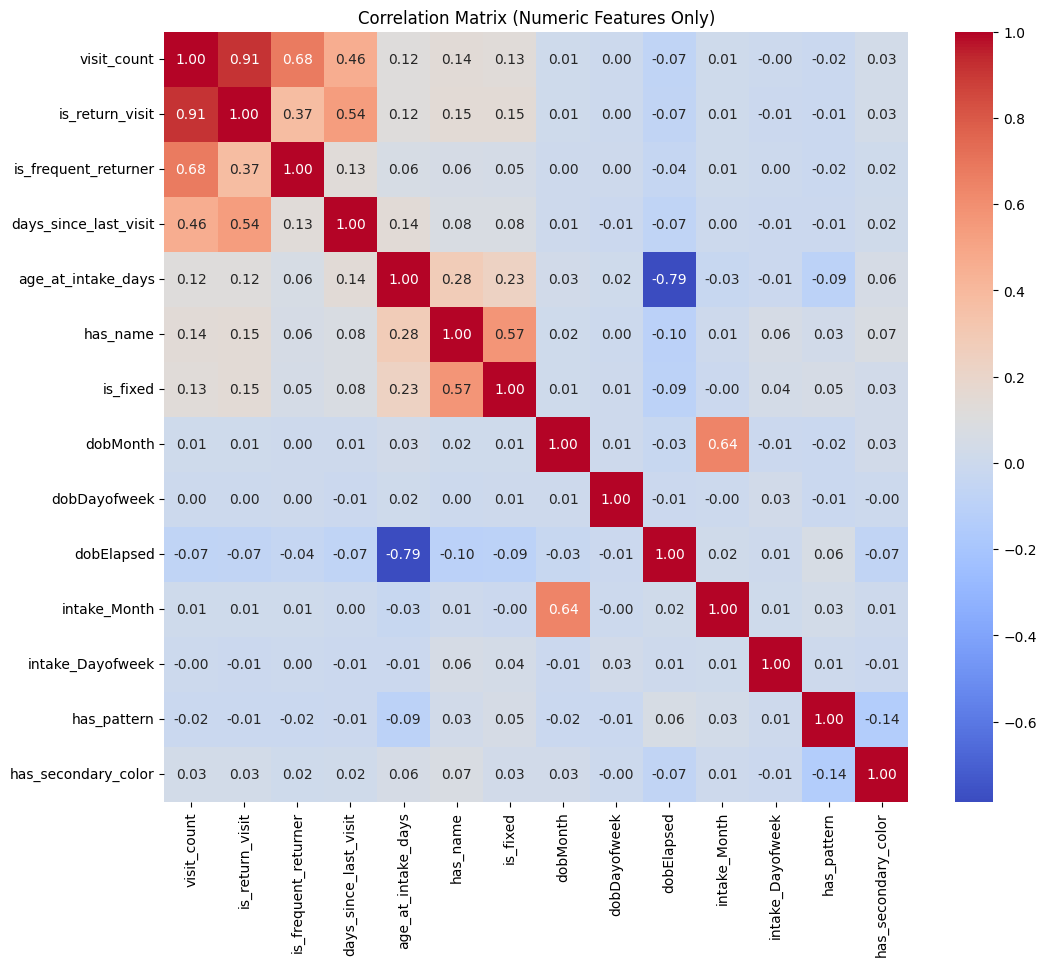

In [33]:
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

Drop *visit_count* as it has high correlation with many features. This information can be captured by the remaining features.

Drop *dobElapsed*, as it gives us similar information to age at intake in days, and age at intake days is more interpretable.

## Dropping more features

In [34]:
df = df.drop(columns=['visit_count', 'dobElapsed','primary_color', 'animal_type', 'secondary_color'])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31441 entries, 3190 to 30595
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    31441 non-null  object 
 1   intake_cond            31441 non-null  object 
 2   intake_type            31441 non-null  object 
 3   intake_subtype         31441 non-null  object 
 4   jurisdiction           31441 non-null  object 
 5   is_return_visit        31441 non-null  int64  
 6   is_frequent_returner   31441 non-null  int64  
 7   days_since_last_visit  31441 non-null  float64
 8   previous_outcome_type  31441 non-null  object 
 9   age_at_intake_days     31441 non-null  int64  
 10  has_name               31441 non-null  int64  
 11  is_fixed               31441 non-null  int64  
 12  dobMonth               31441 non-null  int32  
 13  dobDayofweek           31441 non-null  int32  
 14  intake_Month           31441 non-null  int32  
 15  inta

## Drop null values

In [36]:
df = df.dropna()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31441 entries, 3190 to 30595
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    31441 non-null  object 
 1   intake_cond            31441 non-null  object 
 2   intake_type            31441 non-null  object 
 3   intake_subtype         31441 non-null  object 
 4   jurisdiction           31441 non-null  object 
 5   is_return_visit        31441 non-null  int64  
 6   is_frequent_returner   31441 non-null  int64  
 7   days_since_last_visit  31441 non-null  float64
 8   previous_outcome_type  31441 non-null  object 
 9   age_at_intake_days     31441 non-null  int64  
 10  has_name               31441 non-null  int64  
 11  is_fixed               31441 non-null  int64  
 12  dobMonth               31441 non-null  int32  
 13  dobDayofweek           31441 non-null  int32  
 14  intake_Month           31441 non-null  int32  
 15  inta

# ML models

## H2O Automl

### Initialisation

In [38]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,7 mins 07 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 19 days
H2O_cluster_name:,H2O_from_python_atharvavyas_ku62gu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.978 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Feature set definition

In [40]:
X = df.drop(columns=['outcome_type_grouped'])

## Defining the target

In [41]:
y = df['outcome_type_grouped']

## Train-test split

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Dataframe for H20

In [43]:
# Create DataFrames for H2O
train_df = X_train.copy()
train_df['outcome_type_grouped'] = y_train

test_df = X_test.copy()
test_df['outcome_type_grouped'] = y_test

## Creating H20 frames

In [44]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Defining target variable & feature set

In [45]:
target = 'outcome_type_grouped'
feature_names = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction',
                'is_return_visit', 'is_frequent_returner', 'days_since_last_visit',
                'previous_outcome_type', 'age_at_intake_days', 'has_name', 'is_fixed',
                'dobMonth', 'dobDayofweek', 'intake_Month', 'intake_Dayofweek',
                'intake_Elapsed', 'primary_base_color', 'has_pattern', 'has_secondary_color',
                'animal_type_grouped']

## Setting target variable as a categorical variable

In [46]:
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

## AutoML run

In [48]:
aml = H2OAutoML(
    max_runtime_secs=7200,  # 2 hour
    max_models=20,
    seed=42,
    sort_metric='AUTO'  # or 'logloss', 'mean_per_class_error' for multi-class
)

In [49]:
aml.train(x=feature_names, y=target, training_frame=train_h2o)

AutoML progress: |
14:23:57.440: AutoML: XGBoost is not available; skipping it.

█
14:24:03.784: GLM_1_AutoML_1_20250717_142357 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 140 out of bounds for length 140

██████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),20/20
# GBM base models (used / total),9/9
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),9/9
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


### Model Leaderboard

In [50]:
print(aml.leaderboard.head())

model_id                                                   mean_per_class_error    logloss      rmse       mse
StackedEnsemble_AllModels_1_AutoML_1_20250717_142357                   0.360817   0.95458   0.563895  0.317977
StackedEnsemble_BestOfFamily_1_AutoML_1_20250717_142357                0.367627   0.964421  0.567194  0.321709
GBM_4_AutoML_1_20250717_142357                                         0.370361   0.973016  0.565533  0.319828
GBM_grid_1_AutoML_1_20250717_142357_model_5                            0.371589   0.979316  0.566813  0.321277
GBM_grid_1_AutoML_1_20250717_142357_model_4                            0.371761   0.986218  0.563721  0.317781
DRF_1_AutoML_1_20250717_142357                                         0.374262   1.08697   0.57999   0.336388
GBM_3_AutoML_1_20250717_142357                                         0.377296   0.985668  0.573304  0.328677
GBM_2_AutoML_1_20250717_142357                                         0.380083   0.990177  0.576205  0.332012
G

### Best model

In [51]:
best_model = aml.leader

### Making predictions

In [52]:
predictions = best_model.predict(test_h2o)

predictions_df = predictions.as_data_frame()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


### Performance on test set

In [53]:
performance = best_model.predict(test_h2o)
print(performance)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
predict       Adoption    Euthanasia       Other     Rescue    Return to Owner    Transfer
Transfer    0.0771808     0.0790381   0.0340268   0.0717712        0.0193335    0.71865
Adoption    0.868184      0.00569215  0.00972477  0.0349595        0.057275     0.0241641
Rescue      0.00527468    0.292876    0.130568    0.541797         0.000661022  0.0288228
Euthanasia  0.00109558    0.940516    0.0326807   0.0136871        0.00219757   0.00982334
Adoption    0.534023      0.0398241   0.0358695   0.315117         0.0515653    0.0236013
Transfer    0.0075284     0.068661    0.0763404   0.0808467        0.00153433   0.765089
Adoption    0.836455      0.00621051  0.0644384   0.0496835        0.00537587   0.037837
Other       0.0934723     0.0932273   0.390276    0.139871         0.00887445   0.274279
Rescue      0.113783      0.04911     0.0333492   0.745148         0.0105741    0.0480364
Rescue  

### Shutdown H20 when done

In [54]:
h2o.shutdown()

H2O session _sid_9c87 closed.


## XGBoost

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define target and features
target = 'outcome_type_grouped'
feature_names = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction', 
                 'is_return_visit', 'is_frequent_returner', 'days_since_last_visit', 
                 'previous_outcome_type', 'age_at_intake_days', 'has_name', 'is_fixed', 
                 'dobMonth', 'dobDayofweek', 'intake_Month', 'intake_Dayofweek', 
                 'intake_Elapsed', 'primary_base_color', 'has_pattern', 'has_secondary_color', 
                 'animal_type_grouped']

def preprocess_data(df):
    """
    Preprocess the data for XGBoost training
    """
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values
    print("Missing values before preprocessing:")
    print(df_processed[feature_names + [target]].isnull().sum())
    
    # Fill missing values for categorical variables with 'Unknown'
    categorical_features = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 
                           'jurisdiction', 'previous_outcome_type', 'primary_base_color', 
                           'animal_type_grouped']
    
    for col in categorical_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('Unknown')
    
    # Fill missing values for numerical variables with median
    numerical_features = ['days_since_last_visit', 'age_at_intake_days', 'intake_Elapsed']
    for col in numerical_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # Fill missing values for boolean variables with False
    boolean_features = ['is_return_visit', 'is_frequent_returner', 'has_name', 'is_fixed', 
                       'has_pattern', 'has_secondary_color']
    for col in boolean_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(False)
    
    # Fill missing values for integer variables with mode
    integer_features = ['dobMonth', 'dobDayofweek', 'intake_Month', 'intake_Dayofweek']
    for col in integer_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 0)
    
    return df_processed

def encode_categorical_features(df_train, df_test, categorical_features):
    """
    Encode categorical features using LabelEncoder
    """
    label_encoders = {}
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()
    
    for col in categorical_features:
        if col in df_train_encoded.columns:
            le = LabelEncoder()
            
            # Fit on training data
            df_train_encoded[col] = le.fit_transform(df_train_encoded[col].astype(str))
            
            # Transform test data, handling unseen categories
            test_categories = df_test_encoded[col].astype(str)
            df_test_encoded[col] = test_categories.apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
            
            label_encoders[col] = le
    
    return df_train_encoded, df_test_encoded, label_encoders

def train_xgboost_classifier(X_train, y_train, X_test, y_test):
    """
    Train XGBoost classifier with hyperparameter tuning
    """
    # Encode target variable
    le_target = LabelEncoder()
    y_train_encoded = le_target.fit_transform(y_train)
    y_test_encoded = le_target.transform(y_test)
    
    print(f"Target classes: {le_target.classes_}")
    print(f"Training set class distribution: {Counter(y_train_encoded)}")
    
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Create XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    print("Starting hyperparameter tuning...")
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_classifier,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train_encoded)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=le_target.classes_))
    
    return best_model, le_target, y_pred, y_pred_proba

def plot_feature_importance(model, feature_names, top_n=15):
    """
    Plot feature importance
    """
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df.head(top_n), x='importance', y='feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def main(df):
    """
    Main function to run the XGBoost classifier pipeline
    """
    print("Starting XGBoost Classification Pipeline...")
    print(f"Dataset shape: {df.shape}")
    
    # Check if all required columns exist
    missing_cols = [col for col in feature_names + [target] if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing columns in dataset: {missing_cols}")
        return
    
    # Preprocess data
    df_processed = preprocess_data(df)
    
    # Prepare features and target
    X = df_processed[feature_names]
    y = df_processed[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    # Identify categorical features
    categorical_features = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 
                           'jurisdiction', 'previous_outcome_type', 'primary_base_color', 
                           'animal_type_grouped']
    
    # Encode categorical features
    X_train_encoded, X_test_encoded, label_encoders = encode_categorical_features(
        X_train, X_test, categorical_features
    )
    
    # Train XGBoost classifier
    model, le_target, y_pred, y_pred_proba = train_xgboost_classifier(
        X_train_encoded, y_train, X_test_encoded, y_test
    )
    
    # Plot feature importance
    feature_importance_df = plot_feature_importance(model, feature_names)
    
    # Plot confusion matrix
    y_test_encoded = le_target.transform(y_test)
    plot_confusion_matrix(y_test_encoded, y_pred, le_target.classes_)
    
    # Print top features
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))
    
    return model, le_target, label_encoders, feature_importance_df

# Usage example:
# Assuming you have a DataFrame called 'df' with your data
# model, le_target, label_encoders, feature_importance = main(df)

# To make predictions on new data:
def predict_new_data(new_df, model, le_target, label_encoders):
    """
    Make predictions on new data
    """
    # Preprocess new data
    new_df_processed = preprocess_data(new_df)
    
    # Encode categorical features
    new_df_encoded = new_df_processed[feature_names].copy()
    
    categorical_features = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 
                           'jurisdiction', 'previous_outcome_type', 'primary_base_color', 
                           'animal_type_grouped']
    
    for col in categorical_features:
        if col in new_df_encoded.columns and col in label_encoders:
            le = label_encoders[col]
            new_df_encoded[col] = new_df_encoded[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
    
    # Make predictions
    predictions = model.predict(new_df_encoded)
    prediction_proba = model.predict_proba(new_df_encoded)
    
    # Decode predictions
    decoded_predictions = le_target.inverse_transform(predictions)
    
    return decoded_predictions, prediction_proba

Starting XGBoost Classification Pipeline...
Dataset shape: (31843, 22)
Missing values before preprocessing:
sex                      0
intake_cond              0
intake_type              0
intake_subtype           0
jurisdiction             0
is_return_visit          0
is_frequent_returner     0
days_since_last_visit    0
previous_outcome_type    0
age_at_intake_days       0
has_name                 0
is_fixed                 0
dobMonth                 0
dobDayofweek             0
intake_Month             0
intake_Dayofweek         0
intake_Elapsed           0
primary_base_color       0
has_pattern              0
has_secondary_color      0
animal_type_grouped      0
outcome_type_grouped     0
dtype: int64
Training set size: 25474
Test set size: 6369
Target classes: ['Adoption' 'Euthanasia' 'Other' 'Rescue' 'Return to Owner' 'Transfer']
Training set class distribution: Counter({np.int64(3): 5984, np.int64(0): 5293, np.int64(1): 4702, np.int64(5): 4168, np.int64(4): 2683, np.int64(2): 26

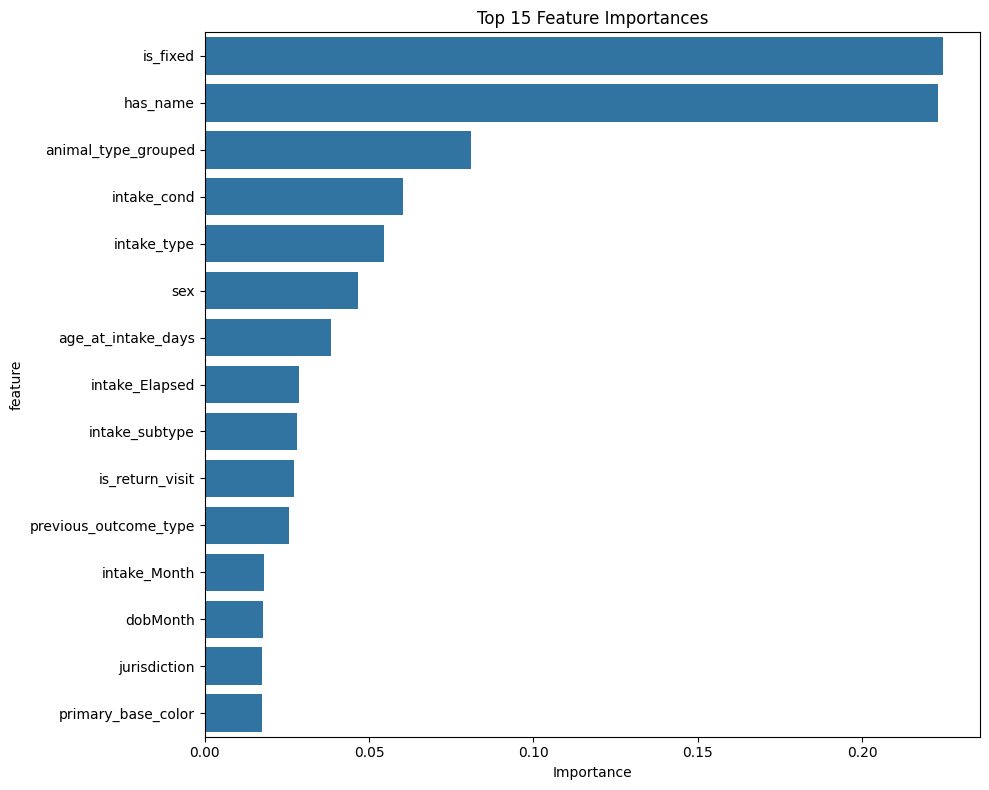

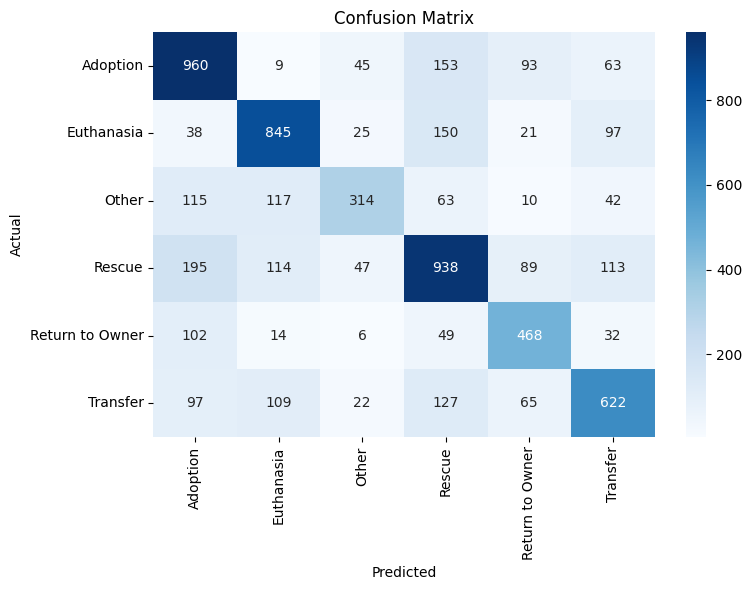


Top 10 Most Important Features:
                feature  importance
11             is_fixed    0.224654
10             has_name    0.222984
20  animal_type_grouped    0.081032
1           intake_cond    0.060468
2           intake_type    0.054673
0                   sex    0.046629
9    age_at_intake_days    0.038412
16       intake_Elapsed    0.028825
3        intake_subtype    0.028030
5       is_return_visit    0.027266
Missing values before preprocessing:
sex                      0
intake_cond              0
intake_type              0
intake_subtype           0
jurisdiction             0
is_return_visit          0
is_frequent_returner     0
days_since_last_visit    0
previous_outcome_type    0
age_at_intake_days       0
has_name                 0
is_fixed                 0
dobMonth                 0
dobDayofweek             0
intake_Month             0
intake_Dayofweek         0
intake_Elapsed           0
primary_base_color       0
has_pattern              0
has_secondary_color  

In [61]:
# Load your data into a DataFrame called 'df'
model, le_target, label_encoders, feature_importance = main(df)

# To make predictions on new data:
predictions, probabilities = predict_new_data(df, model, le_target, label_encoders)

## Additional feature engineering

Let's add a few ner features here:
1. Breeding season indicators: Kittens & puppies are born in high numbers in the wild during specific times of the year. This get captured with the new feature
2. Age bins: Age is now binned into smaller categories instead of using just numbers
3. Interaction terms: To capture interaction between seasonal characteristics and animal types, young cats and young dogs are identified through engineered interaction terms. More recent return visits are also captured by interacting *True* recently visited animals & animals that have visited the shelter in less than 30 days.

In [38]:
def create_age_bins(df):
    """Create age bins from age_at_intake_days"""
    df = df.copy()
    df['age_category'] = pd.cut(df['age_at_intake_days'], 
                               bins=[0, 365, 1095, 2555, np.inf],
                               labels=['puppy_kitten', 'young_adult', 'adult', 'senior'])
    return df



def create_breeding_season_features(df):
    """Create breeding season indicators"""
    df = df.copy()
    
    # Spring/Summer breeding season (March-August)
    df['breeding_season'] = df['intake_Month'].isin([3, 4, 5, 6, 7, 8]).astype(int)
    
    # Kitten season (April-October)
    df['kitten_season'] = df['intake_Month'].isin([4, 5, 6, 7, 8, 9, 10]).astype(int)
    
    # Peak kitten season (May-July)
    df['peak_kitten_season'] = df['intake_Month'].isin([5, 6, 7]).astype(int)
    
    return df

def create_interaction_features(df):
    """Create interaction features"""
    df = df.copy()
    
    # Return visit patterns
    df['return_visit_recent'] = ((df['is_return_visit'] == 1) & 
                                (df['days_since_last_visit'] < 30)).astype(int)
    
    # Age-animal type interaction
    df['young_cat'] = ((df['animal_type_grouped'] == 'Cat') & 
                       (df['age_at_intake_days'] < 365)).astype(int)
    df['young_dog'] = ((df['animal_type_grouped'] == 'Dog') & 
                       (df['age_at_intake_days'] < 365)).astype(int)
    
    return df

def feature_engineering_pipeline(df):
    """Complete feature engineering pipeline"""
    df = create_age_bins(df)
    df = create_breeding_season_features(df)
    df = create_interaction_features(df)
    
    return df

# =====================================
# APPLY FEATURE ENGINEERING
# =====================================

# Apply feature engineering to your DataFrame
df_engineered = feature_engineering_pipeline(df)

# Updated feature list with new features
features = ['sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction',
           'is_return_visit', 'is_frequent_returner', 'days_since_last_visit',
           'previous_outcome_type', 'age_at_intake_days', 'has_name', 'is_fixed',
           'dobMonth', 'dobDayofweek', 'intake_Month', 'intake_Dayofweek',
           'primary_base_color', 'has_pattern', 'has_secondary_color',
           'animal_type_grouped',
           # New engineered features
           'age_category', 'breeding_season', 'kitten_season',
           'peak_kitten_season', 'return_visit_recent',
           'young_cat', 'young_dog']

In [39]:
X = df_engineered[features]
y = df_engineered['outcome_type_grouped']

## AutoML run 2

### Initialise H20

In [40]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /system/conda/miniconda3/envs/cloudspace/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5x_u_vb_
  JVM stdout: /tmp/tmp5x_u_vb_/h2o_atharvavyas1_started_from_python.out
  JVM stderr: /tmp/tmp5x_u_vb_/h2o_atharvavyas1_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 20 days
H2O_cluster_name:,H2O_from_python_atharvavyas1_wnwkxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.904 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Train-test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Creatingt dataframes for H20

In [42]:
train_df = X_train.copy()
train_df['outcome_type_grouped'] = y_train

test_df = X_test.copy()
test_df['outcome_type_grouped'] = y_test


### Converting to H20 frames

In [43]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Defining target variable

In [44]:
target = 'outcome_type_grouped'
feature_names = [col for col in features]

### Setting target as categorical

In [45]:
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

### Calculating class sampling factors for balancing

In [46]:
class_counts = train_h2o[target].table().as_data_frame()
print("Class distribution:")
print(class_counts)

Class distribution:
  outcome_type_grouped  Count
0             Adoption   5341
1           Euthanasia   4570
2                Other   2648
3               Rescue   5933
4      Return to Owner   2612
5             Transfer   4048


### Running AutoML with improved settings

In [47]:
aml = H2OAutoML(
    max_runtime_secs=14400,  # 1 hour
    max_models=30,
    seed=42,
    sort_metric='mean_per_class_error',  # Better for imbalanced classes
    balance_classes=True,  # Handle class imbalance
    max_after_balance_size=2.0,  # Prevent excessive oversampling
    stopping_rounds=10,  # Early stopping
    stopping_tolerance=0.001,  # Early stopping tolerance
    stopping_metric='mean_per_class_error',
    nfolds=5,  # 5-fold CV
    verbosity='info'
)

### AutoML 2nd run

In [48]:
print("Starting AutoML training...")
aml.train(x=feature_names, y=target, training_frame=train_h2o)

Starting AutoML training...
AutoML progress: |
05:50:00.968: Project: AutoML_1_20250718_55000
05:50:00.969: Stopping tolerance set by the user: 0.001
05:50:00.969: Stopping tolerance set by the user is < 70% of the recommended default of 0.006305415903816478, so models may take a long time to converge or may not converge at all.
05:50:00.970: Build control seed: 42
05:50:00.973: training frame: Frame key: AutoML_1_20250718_55000_training_py_1_sid_852d    cols: 28    rows: 25152  chunks: 1    size: 500416  checksum: -4157440894311790916
05:50:00.974: validation frame: NULL
05:50:00.974: leaderboard frame: NULL
05:50:00.974: blending frame: NULL
05:50:00.974: response column: outcome_type_grouped
05:50:00.974: fold column: null
05:50:00.974: weights column: null
05:50:00.991: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1

███
05:54:12.44: New leader: XGBoost_1_AutoML_1_20250718_55000, mean_per_class_error: 0.4153818263499614
05:54:12.57: AutoML: starting GLM_1_AutoML_1_20250718_55000 model training


05:54:14.321: GLM_1_AutoML_1_20250718_55000 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 149 out of bounds for length 149
05:54:14.341: AutoML: starting GBM_1_AutoML_1_20250718_55000 model training

████████████████████
05:56:49.413: New leader: GBM_1_AutoML_1_20250718_55000, mean_per_class_error: 0.4095396151133548
05:56:49.415: AutoML: starting XGBoost_2_AutoML_1_20250718_55000 model training

█████████████████████
06:00:44.950: AutoML: starting DRF_1_AutoML_1_20250718_55000 model training

███
06:02:39.233: AutoML: starting GBM_2_AutoML_1_20250718_55000 model training

█
06:04:13.775: New leader: GBM_2_AutoML_1_20250718_55000, mean_per_class_error: 0.4044373529347732
06:04:13.776: AutoML: starting GBM_3_AutoML_1_20250718_55000 model training

██
06:06:00.459: AutoML: starting GBM_4

key,value
Stacking strategy,cross_validation
Number of base models (used / total),30/30
# GBM base models (used / total),10/10
# XGBoost base models (used / total),11/11
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),7/7
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### Results and evaluation

In [49]:
print("\n" + "="*50)
print("LEADERBOARD")
print("="*50)
print(aml.leaderboard.head(10))


LEADERBOARD
model_id                                                  mean_per_class_error    logloss      rmse       mse
StackedEnsemble_AllModels_1_AutoML_1_20250718_55000                   0.381412    1.00149  0.580996  0.337556
StackedEnsemble_BestOfFamily_1_AutoML_1_20250718_55000                0.388261    1.01639  0.585521  0.342835
XGBoost_grid_1_AutoML_1_20250718_55000_model_2                        0.398224    1.0995   0.57841   0.334559
XGBoost_grid_1_AutoML_1_20250718_55000_model_5                        0.399838    1.12012  0.575799  0.331545
GBM_grid_1_AutoML_1_20250718_55000_model_5                            0.401543    1.07983  0.58196   0.338678
XGBoost_grid_1_AutoML_1_20250718_55000_model_1                        0.402332    1.19524  0.575637  0.331358
XGBoost_grid_1_AutoML_1_20250718_55000_model_3                        0.402731    1.11931  0.580382  0.336843
XGBoost_grid_1_AutoML_1_20250718_55000_model_7                        0.403194    1.1075   0.579385  0.3356

### Best model

In [50]:
best_model = aml.leader
print(f"\nBest model: {best_model.model_id}")


Best model: StackedEnsemble_AllModels_1_AutoML_1_20250718_55000


### Performance on test set

In [51]:
print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
test_performance = best_model.model_performance(test_h2o)
print(test_performance)


TEST SET PERFORMANCE


ModelMetricsMultinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.33403609437169884
RMSE: 0.5779585576593695
LogLoss: 0.9914904382658757
Null degrees of freedom: 6288
Residual degrees of freedom: 5993
Null deviance: 21958.457859019712
Residual deviance: 12470.966732508186
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Adoption    Euthanasia    Other    Rescue    Return to Owner    Transfer    Error     Rate
----------  ------------  -------  --------  -----------------  ----------  --------  -------------
982         21            50       141       93                 48          0.264419  353 / 1,335
28          829

### Make predictions

In [52]:
predictions = best_model.predict(test_h2o)
predictions_df = predictions.as_data_frame()

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


### SHAP analysis

In [53]:
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

try:
    # SHAP values for the best model
    shap_values = best_model.predict_contributions(test_h2o)
    shap_df = shap_values.as_data_frame()
    
    # Feature importance from SHAP
    shap_importance = shap_df.drop('BiasTerm', axis=1).abs().mean().sort_values(ascending=False)
    
    print("Top 15 Most Important Features (SHAP):")
    print(shap_importance.head(15))
    
    # You can also get H2O's variable importance
    print("\nH2O Variable Importance:")
    var_imp = best_model.varimp(use_pandas=True)
    print(var_imp.head(15))
    
except Exception as e:
    print(f"SHAP analysis not available for this model type: {e}")
    # Fallback to H2O variable importance
    print("H2O Variable Importance:")
    var_imp = best_model.varimp(use_pandas=True)
    print(var_imp.head(15))


SHAP ANALYSIS
contributions progress: | (failed)
SHAP analysis not available for this model type: Job with key $03017f00000132d4ffffffff$_a55506acd286545c11c9e6e18d0342bb failed with an exception: water.exceptions.H2OIllegalArgumentException: unimplemented: StackedEnsemble supports contribution calculation only with a background frame.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: unimplemented: StackedEnsemble supports contribution calculation only with a background frame.
	at water.H2O.unimpl(H2O.java:1385)
	at hex.ensemble.StackedEnsembleModel.scoreContributions(StackedEnsembleModel.java:279)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:549)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166

AttributeError: 'NoneType' object has no attribute 'head'

### Additional analysis

In [86]:
print("\n" + "="*50)
print("CROSS-VALIDATION SUMMARY")
print("="*50)
print(f"CV Mean Per Class Error: {aml.leader.mean_per_class_error()}")
print(f"CV Log Loss: {aml.leader.logloss()}")


CROSS-VALIDATION SUMMARY
CV Mean Per Class Error: 0.015178484244871483
CV Log Loss: 0.14879818043999615


### Class-specific performance

In [87]:
print("\n" + "="*50)
print("PER-CLASS PERFORMANCE")
print("="*50)
cm = test_performance.confusion_matrix()
print(cm)


PER-CLASS PERFORMANCE
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Adoption    Euthanasia    Other    Rescue    Return to Owner    Transfer    Error     Rate
----------  ------------  -------  --------  -----------------  ----------  --------  -------------
969         8             46       147       90                 63          0.267574  354 / 1,323
44          853           36       149       18                 76          0.27466   323 / 1,176
125         102           301      86        6                  41          0.544629  360 / 661
175         100           44       1008      73                 96          0.326203  488 / 1,496
118         18            9        60        431                35          0.357675  240 / 671
107         92            22       119       66                 636         0.389635  406 / 1,042
1538        1173          458      1569      684                947         0.34087   2,171 / 6,369


### Shutdown H20

In [88]:
h2o.shutdown()

H2O session _sid_a253 closed.
